In [6]:
# --- Jupyter Starter Pack ---

# autoreload: refresh code on every cell run
%reload_ext autoreload
%autoreload 2

# clean warnings
import warnings
warnings.filterwarnings("ignore")

# numpy / pandas nicer display
import numpy as np
np.set_printoptions(precision=4, suppress=True)

# matplotlib defaults
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120

# tqdm in notebooks
from tqdm.notebook import tqdm

# optional: make exceptions show only the important frame
%config InlineBackend.figure_format = "retina"

import torch, gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [7]:
from unet import UNetModel
from train_score import marginal_prob_std, diffusion_coeff
import torch
import functools

device = 'cuda'
sigma =  25.0

cfg = {
	"model": {
		"in_channels": 1,
		"out_channels": 1,
		"model_channels": 32,
		"channel_mult": [1, 2, 4],
		"num_res_blocks": 1,
		"attention_resolutions": [],
		"max_period": 0.005,
	},
}

marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma, device=device)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma, device=device)
UNet_model = UNetModel(marginal_prob_std=marginal_prob_std_fn, **cfg["model"])

score_model = UNet_model.to(device)
score_model.load_state_dict(torch.load('ckpt.pt', map_location=device))
score_model.eval()

from cnet import Net
classifier = Net().to(device)
classifier.load_state_dict(torch.load('cnet.pt', map_location=device))

<All keys matched successfully>

In [8]:
cfg = {
	"control_net": {
		"in_channels": 2,
		"out_channels": 1,
		"model_channels": 32,
		"channel_mult": [1, 2],
		"num_res_blocks": 1,
		"attention_resolutions": [],
		"max_period": 0.005,
	},
}

marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma, device=device)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma, device=device)
control_net_1 = UNetModel(marginal_prob_std=marginal_prob_std_fn, **cfg["control_net"]).to(device)
control_net_2 = UNetModel(marginal_prob_std=marginal_prob_std_fn, **cfg["control_net"]).to(device)

In [9]:
def Controlled_Euler_Maruyama_sampler(
    score_model,
    control_net_1,
    control_net_2,
    marginal_prob_std,
    diffusion_coeff,
    batch_size=8,
    num_steps=500,
    device='cuda',
    eps=1e-3
):
    t = torch.ones(batch_size, device=device)
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    
    # Initialize separate latent codes
    x1 = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    x2 = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    
    mask_top = torch.zeros((1, 1, 28, 28), device=device); mask_top[:, :, :14, :] = 1.0
    mask_bot = torch.zeros((1, 1, 28, 28), device=device); mask_bot[:, :, 14:, :] = 1.0

    with torch.no_grad():
        for time_step in range(len(time_steps)):
            batch_time_step = torch.ones(batch_size, device=device) * time_steps[time_step]
    
            g = diffusion_coeff(batch_time_step)
            g_sq = (g**2)[:, None, None, None]
            
            Y_t = (x1 * mask_top) + (x2 * mask_bot)
            
            u1 = control_net_1(torch.cat([x1, Y_t], dim=1), batch_time_step)
            u2 = control_net_2(torch.cat([x2, Y_t], dim=1), batch_time_step)
                        
            drift1 = g_sq * score_model(x1, batch_time_step)
            x1 = x1 + (drift1 + u1) * step_size + torch.sqrt(step_size) * g[:,None,None,None] * torch.randn_like(x1)
            
            drift2 = g_sq * score_model(x2, batch_time_step)
            x2 = x2 + (drift2 + u2) * step_size + torch.sqrt(step_size) * g[:,None,None,None] * torch.randn_like(x2)

    return (x1 * mask_top) + (x2 * mask_bot)

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def generate_and_plot_samples(
    score_model,
    control_net_1,
    control_net_2,
    classifier,
    marginal_prob_std_fn,
    diffusion_coeff_fn,
    sample_batch_size=64,
    num_steps=500,
    device='cuda',
    eps=1e-3,
):
    """Generate samples using Controlled Euler-Maruyama and plot with predicted class labels."""

    # eval mode
    score_model.eval()
    control_net_1.eval()
    control_net_2.eval()
    classifier.eval()

    # sampling
    samples = Controlled_Euler_Maruyama_sampler(
        score_model,
        control_net_1,
        control_net_2,
        marginal_prob_std_fn,
        diffusion_coeff_fn,
        batch_size=sample_batch_size,
        num_steps=num_steps,
        device=device,
        eps=eps
    )

    samples = samples.clamp(0.0, 1.0)

    # classify
    with torch.no_grad():
        logits = classifier(samples.to(device))
        preds = logits.argmax(dim=1).cpu()

    # grid size
    B = samples.size(0)
    nrow = int(np.sqrt(B))
    ncol = int(np.ceil(B / nrow))

    # plotting
    _, axes = plt.subplots(nrow, ncol, figsize=(6, 6))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < B:
            img = samples[i].cpu().squeeze(0)
            ax.imshow(img, cmap='gray', vmin=0., vmax=1.)
            ax.set_title(str(preds[i].item()), fontsize=8)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    return samples, preds

Starting training...


Training control policy:   0%|          | 0/300 [00:05<?, ?it/s, loss=46.7851, 46.0489]

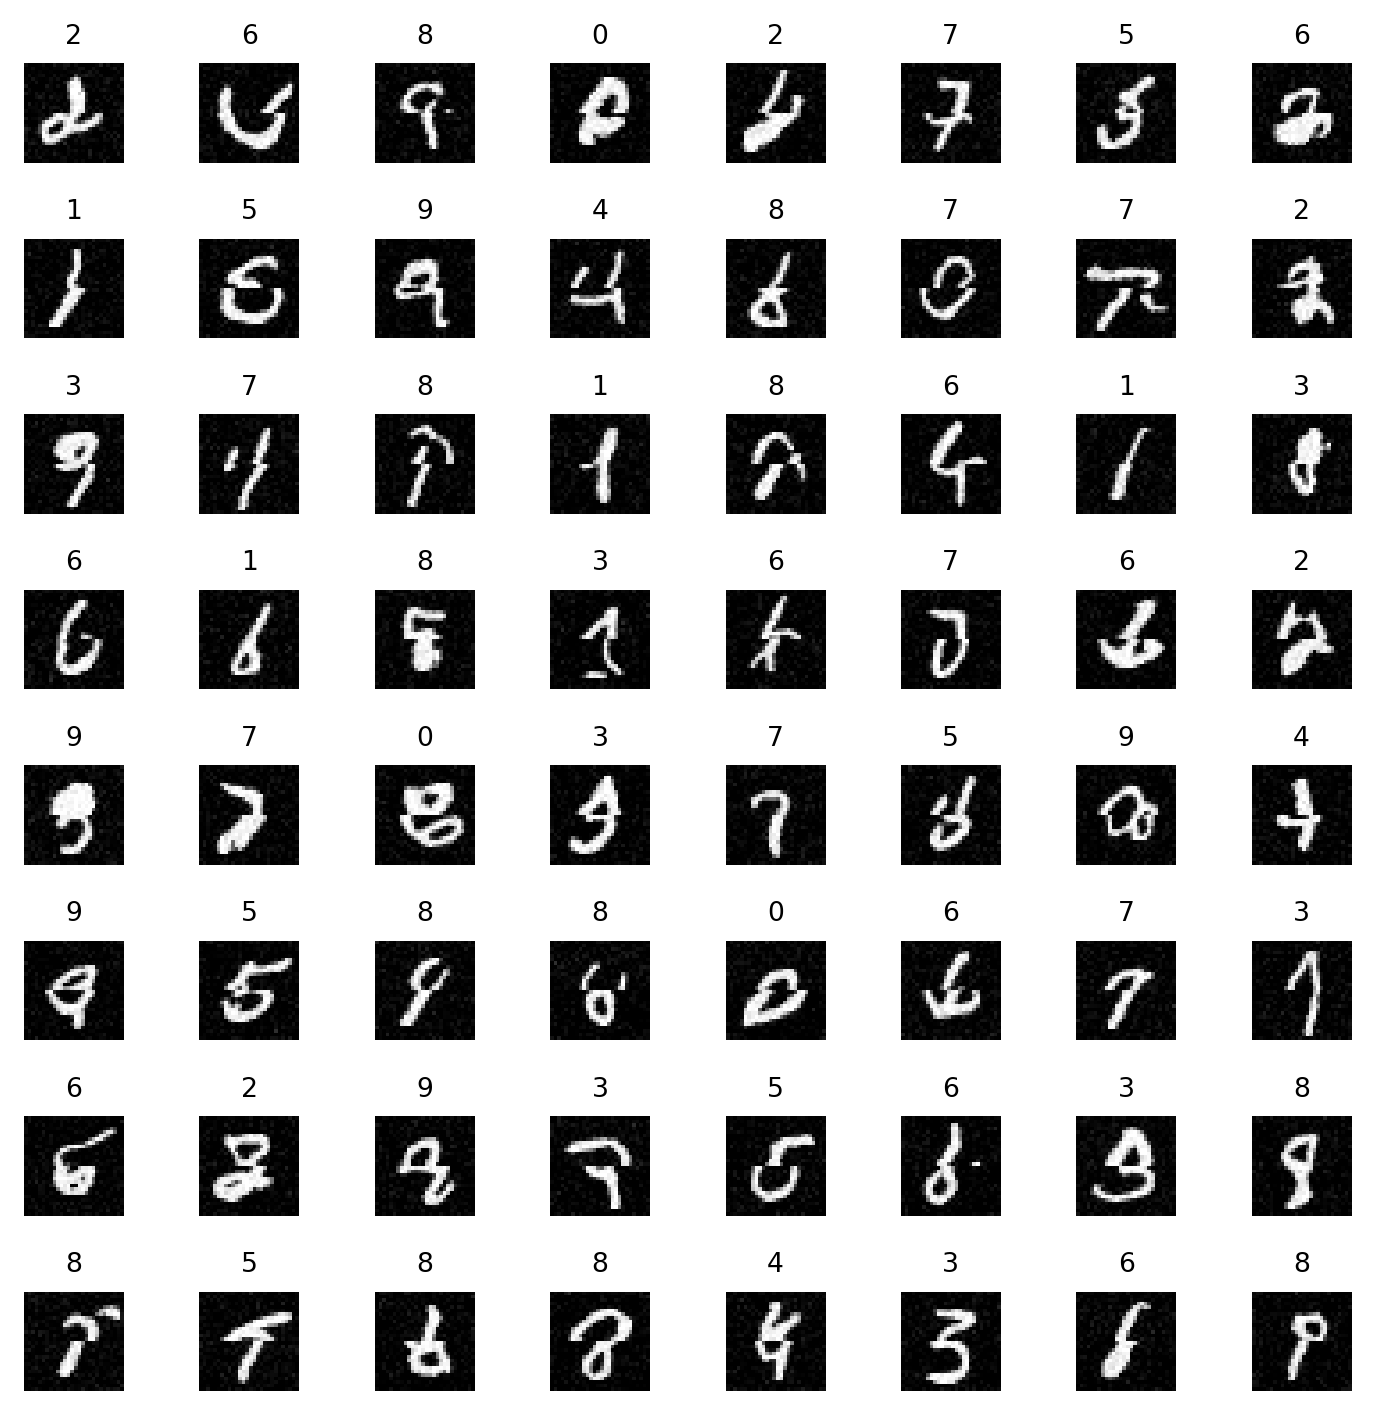

Training control policy:  33%|███▎      | 100/300 [09:20<18:14,  5.47s/it, loss=3.6292, 3.4944] 

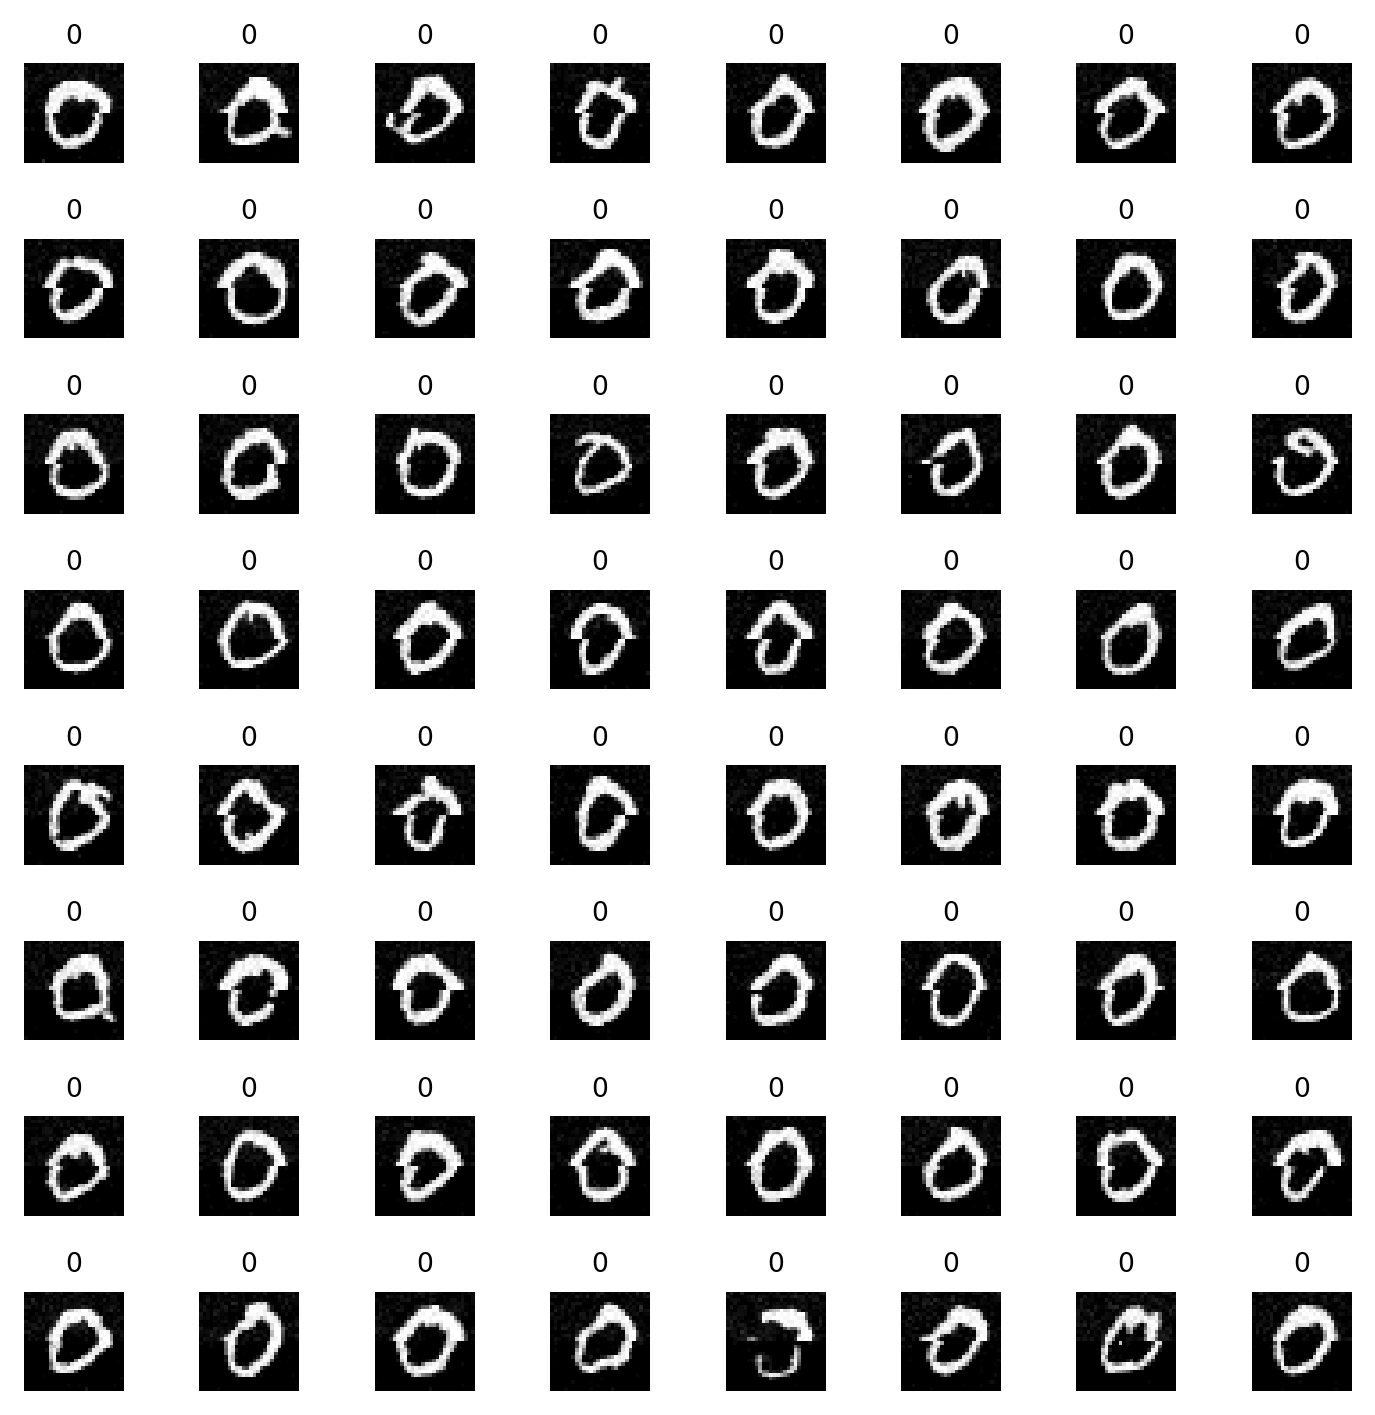

Training control policy:  34%|███▍      | 103/300 [09:41<18:32,  5.65s/it, loss=3.5623, 4.0615]


KeyboardInterrupt: 

In [11]:
from torch.nn import functional as F
import torch

# PARAMETERS
NUM_STEPS = 500
BATCH_SIZE = 16
OUTER_ITERS = 300
INNER_ITERS = 5
LAMBDA_REG = 0.01

def train_control_policy(
    score_model,
    classifier,
    control_net_1,
    control_net_2,
    marginal_prob_std,
    diffusion_coeff,
    optimizer,
    target_digit=0,
    num_steps=100,
    batch_size=64,
    device='cuda',
    eps=1e-3,
    lambda_reg=0.1,      # Cost of using control
    running_class_reg=1.0, # New: Weight for the running classifier loss
    player_idx=0,
):   
    """Train one control policy given the other is fixed."""
    optimizer.zero_grad()

    t = torch.ones(batch_size, device=device)
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    
    def get_std(time_tensor):
        return marginal_prob_std(time_tensor)[:, None, None, None]

    init_x1 = torch.randn(batch_size, 1, 28, 28, device=device) * get_std(t)
    init_x2 = torch.randn(batch_size, 1, 28, 28, device=device) * get_std(t)
    
    x1 = init_x1
    x2 = init_x2
    
    # Overlap logic
    mid = 14
    start_overlap = mid - (4 // 2) # 12
    end_overlap   = mid + (4 // 2) # 16

    mask_top = torch.zeros((1, 1, 28, 28), device=device)
    mask_top[:, :, :end_overlap, :] = 1.0
    
    mask_bot = torch.zeros((1, 1, 28, 28), device=device)
    mask_bot[:, :, start_overlap:, :] = 1.0

    cumulative_control_loss = 0
    cumulative_class_loss = 0

    for time_step in range(len(time_steps)):
        batch_time_step = torch.ones(batch_size, device=device) * time_steps[time_step]
        
        g = diffusion_coeff(batch_time_step)
        g_sq = (g**2)[:, None, None, None]
        g_noise = g[:, None, None, None]
        
        Y_t = (x1 * mask_top) + (x2 * mask_bot)
        
        if player_idx == 0:
            u1 = control_net_1(torch.cat([x1, Y_t], dim=1), batch_time_step)
            with torch.no_grad():
                u2 = control_net_2(torch.cat([x2, Y_t], dim=1), batch_time_step)
        elif player_idx == 1:
            with torch.no_grad():
                u1 = control_net_1(torch.cat([x1, Y_t], dim=1), batch_time_step)
            u2 = control_net_2(torch.cat([x2, Y_t], dim=1), batch_time_step)
        else:
            raise ValueError("player_idx must be 0 or 1 - Python indexing")

        current_std = get_std(batch_time_step)
        
        s1 = score_model(x1, batch_time_step)
        s2 = score_model(x2, batch_time_step)
        
        x1_0_hat = x1 + (current_std ** 2) * s1
        x2_0_hat = x2 + (current_std ** 2) * s2
        
        Y_0_hat = (x1_0_hat * mask_top) + (x2_0_hat * mask_bot)
        
        logits_running = classifier(Y_0_hat)
        target_labels = torch.full((batch_size,), target_digit, device=device, dtype=torch.long)
        
        running_loss = F.cross_entropy(logits_running, target_labels)
        cumulative_class_loss += running_loss * step_size

        drift1 = g_sq * s1 
        mean_x1 = x1 + (drift1 + u1) * step_size
        x1 = mean_x1 + torch.sqrt(step_size) * g_noise * torch.randn_like(x1)
        
        drift2 = g_sq * s2 
        mean_x2 = x2 + (drift2 + u2) * step_size
        x2 = mean_x2 + torch.sqrt(step_size) * g_noise * torch.randn_like(x2)
        if player_idx == 0:
            cumulative_control_loss += torch.mean(u1**2) * step_size
        elif player_idx == 1:
            cumulative_control_loss += torch.mean(u2**2) * step_size
        else: 
            raise ValueError("player_idx must be 0 or 1 - Python indexing")

    Y_final = (x1 * mask_top) + (x2 * mask_bot)
    logits = classifier(Y_final)
    target_labels = torch.full((batch_size,), target_digit, device=device, dtype=torch.long)
    class_loss = F.cross_entropy(logits, target_labels)

    total_loss = (lambda_reg * cumulative_control_loss) + \
                 class_loss + \
                 (running_class_reg * cumulative_class_loss)
                 
    total_loss.backward()

    torch.nn.utils.clip_grad_norm_(control_net_1.parameters(), 1.0)
    torch.nn.utils.clip_grad_norm_(control_net_2.parameters(), 1.0)
    optimizer.step()
    
    return total_loss


opt1 = torch.optim.Adam(control_net_1.parameters(), lr=1e-4)
opt2 = torch.optim.Adam(control_net_2.parameters(), lr=1e-4)

print("Starting training...")
from tqdm.auto import tqdm

pbar = tqdm(range(OUTER_ITERS), desc="Training control policy")
for epoch in pbar:
    # ----- update player 0 given player 1 fixed -----
    for i in range(INNER_ITERS):
        loss1 = train_control_policy(
            score_model,
            classifier,
            control_net_1,
            control_net_2,
            marginal_prob_std_fn,
            diffusion_coeff_fn,
            opt1,
            target_digit=0,
            num_steps=25,
            batch_size=BATCH_SIZE,
            device=device,
            eps=1e-3,
            lambda_reg=LAMBDA_REG,
            player_idx=0,
        )
    # ----- update player 1 given player 0 fixed -----
    for i in range(INNER_ITERS):
        loss2 = train_control_policy(
            score_model,
            classifier,
            control_net_1,
            control_net_2,
            marginal_prob_std_fn,
            diffusion_coeff_fn,
            opt2,
            target_digit=0,
            num_steps=25,
            batch_size=BATCH_SIZE,
            device=device,
            eps=1e-3,
            lambda_reg=LAMBDA_REG,
            player_idx=1,
        )
    pbar.set_postfix(loss=f"{loss1.item():.4f}, {loss2.item():.4f}")
    if epoch % 100 == 0:
        generate_and_plot_samples(
            score_model,
            control_net_1,
            control_net_2,
            classifier,
            marginal_prob_std_fn,
            diffusion_coeff_fn,
            sample_batch_size=64,
            num_steps=500,
            device='cuda'
        )

print("\n--- Training Complete ---")


In [ ]:
torch.save(control_net_1.state_dict(), "control_net_1_0_fits.pt")
torch.save(control_net_2.state_dict(), "control_net_2_0_fits.pt")

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

score_model.eval()
control_net_1.eval()
control_net_2.eval()

sample_batch_size = 64
samples = Controlled_Euler_Maruyama_sampler(
    score_model,
    control_net_1,
    control_net_2,
    marginal_prob_std_fn,
    diffusion_coeff_fn,
    batch_size=sample_batch_size,
    num_steps=500,
    device='cuda',
    eps=1e-3
)

samples = samples.clamp(0.0, 1.0)

classifier.eval()
with torch.no_grad():
    logits = classifier(samples.to(device))      # (B, num_classes)
    preds = logits.argmax(dim=1).cpu()          # (B,)

B = samples.size(0)
nrow = int(np.sqrt(B))
ncol = int(np.ceil(B / nrow))

fig, axes = plt.subplots(nrow, ncol, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    if i < B:
        img = samples[i].cpu().squeeze(0)       # (H, W) for 1-channel
        ax.imshow(img, cmap='gray', vmin=0., vmax=1.)
        ax.set_title(str(preds[i].item()), fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()